In [23]:
import os 
import pandas as pd 
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from qmplot import manhattanplot
os.chdir("/mnt/BioHome/jreyna/jreyna/projects/dchallenge/")
outdir = 'results/main/eqtl/'
os.makedirs(outdir, exist_ok=True)

dice_published = ['CLASSICAL_MONOCYTES', 'B_NAIVE', 'CD4_NAIVE', 'CD8_NAIVE', 'NK_CD16POS']
dice_published += ['CM', 'NB', 'CD4N', 'CD8N', 'NK']
highly_cited_genes = ['BACH2','UBASH3A', 'PTPN22', 'SIRPG', 'CTSH', 'M6PR', 'RGS1']

## Summarize eQTLs

In [2]:
eqtl_fn1 = 'results/main/2021_Nikhil_eQTL/Data/eqtl_sqtl_summ_stats/BLUEPRINT_eQTL/*.txt.gz'
eqtl_fn1 = glob.glob(eqtl_fn1)
eqtl_fn2 = 'results/main/2021_Nikhil_eQTL/Data/eqtl_sqtl_summ_stats/DICE_eQTL//*.txt.gz'
eqtl_fn2 = glob.glob(eqtl_fn2)
get_cell_type = lambda x: os.path.basename(x).split('.')[0]
eqtl_fn2 = [x for x in eqtl_fn2 if get_cell_type(x) in dice_published]
eqtl_fns = eqtl_fn1 + eqtl_fn2

In [3]:
eqtl_data = []
for fn in eqtl_fns:
    df = pd.read_table(fn)

    study = fn.split('/')[5].replace('_eQTL', '')
    cline = fn.split('/')[6].split('.')[0]
    
    df['study'] = study
    df['cline'] = cline 
    
    eqtl_data.append(df)


In [4]:
eqtl_data = pd.concat(eqtl_data)

In [5]:
eqtl_data.head()

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,study,cline
0,RP11-809C18.3,3958,1.04397,193.339,143.536,10:1116997,442418,6.050140e-06,0.437403,0.003996,7.116960e-03,3.315073e-02,BLUEPRINT,Neutrophil
1,WDR37,5379,1.09896,341.843,148.721,10:1108544,13065,1.099870e-07,0.482763,0.000999,1.715620e-04,1.220888e-03,BLUEPRINT,Neutrophil
2,ADARB2,5693,1.02652,381.476,150.294,10:1282530,54456,1.555440e-33,1.067640,0.000999,8.202270e-27,5.319393e-25,BLUEPRINT,Neutrophil
3,RP11-482E14.1,6377,1.03604,509.748,155.394,10:3507739,-21348,3.410100e-07,0.700451,0.000999,6.935080e-04,4.405235e-03,BLUEPRINT,Neutrophil
4,RP11-433J20.2,6735,1.12300,432.924,145.437,10:4392931,325798,3.399140e-06,-0.208851,0.004995,5.987540e-03,2.878668e-02,BLUEPRINT,Neutrophil


In [6]:
eqtl_summary = eqtl_data.groupby(['study', 'cline'])

#### Total number of eQTL's (SNP-gene pairs)

In [7]:
total_eqtls = eqtl_summary.sid.apply(len).reset_index()
total_eqtls.sort_values(['sid', 'study', 'cline'], ascending=[False, True, True], inplace=True)
total_eqtls.head()

,study,cline,sid
0,BLUEPRINT,Monocyte,7716
2,BLUEPRINT,T-cell,7211
1,BLUEPRINT,Neutrophil,6399
4,DICE,CD4_NAIVE,2504
5,DICE,CD8_NAIVE,2373


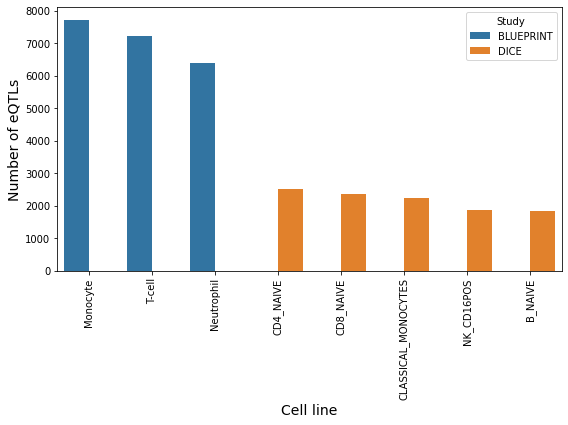

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=total_eqtls.rename(columns={'study': 'Study'}), 
            x='cline',
            y='sid',
            hue='Study')
ax.set_xlabel('Cell line', fontsize=14)
ax.set_ylabel('Number of eQTLs', fontsize=14)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
fn = os.path.join(outdir, 'eqtls_per_celltype.png')
fig.tight_layout()
fig.savefig(fn, dpi=600)

In [9]:
total_eqtls

,study,cline,sid
0,BLUEPRINT,Monocyte,7716
2,BLUEPRINT,T-cell,7211
1,BLUEPRINT,Neutrophil,6399
4,DICE,CD4_NAIVE,2504
5,DICE,CD8_NAIVE,2373
6,DICE,CLASSICAL_MONOCYTES,2252
7,DICE,NK_CD16POS,1882
3,DICE,B_NAIVE,1826


In [10]:
total_eqtls.groupby('study').describe()

sid                                                           \
          count         mean         std     min     25%     50%     75%   
study                                                                      
BLUEPRINT   3.0  7108.666667  664.436854  6399.0  6805.0  7211.0  7463.5   
DICE        5.0  2167.400000  300.306177  1826.0  1882.0  2252.0  2373.0   

                   
              max  
study              
BLUEPRINT  7716.0  
DICE       2504.0

#### Total number of unique SNPs per study + cell line

In [11]:
uniq_snps = eqtl_summary.sid.nunique().reset_index()
uniq_snps.sort_values(['sid', 'study', 'cline'], ascending=[False, True, True], inplace=True)

In [12]:
uniq_snps.groupby('study').describe()

sid                                                           \
          count         mean         std     min     25%     50%     75%   
study                                                                      
BLUEPRINT   3.0  6547.666667  755.469611  5696.0  6253.0  6810.0  6973.5   
DICE        5.0  2080.400000  315.385161  1749.0  1753.0  2165.0  2301.0   

                   
              max  
study              
BLUEPRINT  7137.0  
DICE       2434.0

#### Total number of unique eGenes per study + cell line

In [13]:
uniq_egenes = eqtl_summary.pid.nunique().reset_index()
uniq_egenes.sort_values(['pid', 'study', 'cline'], ascending=[False, True, True], inplace=True)

In [14]:
uniq_egenes.groupby('study').describe()

pid                                                           \
          count         mean         std     min     25%     50%     75%   
study                                                                      
BLUEPRINT   3.0  7108.666667  664.436854  6399.0  6805.0  7211.0  7463.5   
DICE        5.0  2167.400000  300.306177  1826.0  1882.0  2252.0  2373.0   

                   
              max  
study              
BLUEPRINT  7716.0  
DICE       2504.0

#### Making a master

In [15]:
master_eqtl_table = pd.merge(total_eqtls, uniq_snps, on=['study', 'cline'])
master_eqtl_table = pd.merge(master_eqtl_table, uniq_egenes, on=['study', 'cline'])

In [16]:
master_eqtl_table.head()

,study,cline,sid_x,sid_y,pid
0,BLUEPRINT,Monocyte,7716,7137,7716
1,BLUEPRINT,T-cell,7211,6810,7211
2,BLUEPRINT,Neutrophil,6399,5696,6399
3,DICE,CD4_NAIVE,2504,2434,2504
4,DICE,CD8_NAIVE,2373,2301,2373


In [17]:
master_eqtl_table.columns = ['Study', 'Cell Line', 'Number of eQTLs', 'Number of Unique SNPs', 'Number of Unique eGenes']

In [18]:
master_eqtl_table.head()

,Study,Cell Line,Number of eQTLs,Number of Unique SNPs,Number of Unique eGenes
0,BLUEPRINT,Monocyte,7716,7137,7716
1,BLUEPRINT,T-cell,7211,6810,7211
2,BLUEPRINT,Neutrophil,6399,5696,6399
3,DICE,CD4_NAIVE,2504,2434,2504
4,DICE,CD8_NAIVE,2373,2301,2373


In [19]:
fn = os.path.join(outdir, 'description_of_eqtl_study.xlsx')
master_eqtl_table.to_excel(fn, index=False)